# Simple Linear Regression

This chapter (and notebook) will go through linear regression of a single variable. The worked example is testing modeling the hypothesis that the number of minutes a user spends on a social network is linearly dependent on their number of friends. In an equation:

$$ y_i = \alpha x_i + \beta + \epsilon $$

Where $y_i$ is the number of minutes spent on the social network, $x_i$ is the number of friends of that user, $\alpha$ and $\beta$ are learned parameters, and $\epsilon$ is (hopefully small) random error term that accounts for the influence of other factors.

Thus predictions from a linear regressed model come from:

In [54]:
import sys, random, tqdm, math
sys.path.insert(0, "../")
from linalg import Vector
from typing import Tuple
from stats import correlation, standard_deviation, mean
from matplotlib import pyplot as plt
from gradient_descent import gradient_step
import numpy as np

In [4]:
def predict(alpha: float, beta: float, x_i: float) -> float:
    """
    for some alpha, beta, x_i, return the estimate for y_i
    """
    return alpha * x_i + beta

Arbitrary $\alpha$, $\beta$ can give arbitrarily bad predictions for $y_i$ even in the case that a linear model is a good fit for the data. We want to find the $\alpha$, $\beta$ that provide the best fit for the data. To do this, we first need to know how wrong we are:

In [5]:
def error(alpha: float, beta: float, x_i: float, y_i: float) -> float:
    """
    for some alpha, beta, x_i, and true value for y_i, return the difference between our estimate and the real value
    """
    return predict(alpha, beta, x_i) - y_i

This is incomplete in two ways:

1. positive and negative error terms negate each other leading to an incorrect defintion of global 'error' across an $X \rightarrow Y$ dataset.

2. large errors are (should be?) *much* worse than small ones: we want to discourage large errors.

So for a whole dataset of xs and ys, we can sum the square of errors and minimize this to get a good fit

In [8]:
def sum_of_squared_errors(alpha: float, beta: float, xs: Vector, ys: Vector) -> float:
    """
    for some alpha, beta and dataset xs, ys, return the sum of squared errors when predicting ys from xs using alpha and beta
    """
    errors = [error(alpha, beta, x_i, y_i) for x_i, y_i in zip(xs, ys)]
    return sum(e**2 for e in errors)

In [16]:
def least_squares_fit(xs: Vector, ys: Vector) -> Tuple[float, float]:
    """
    Given a dataset represented by xs and ys, return the alpha, beta that provide the least squared error fit for a
    function y_i = alpha * x_i + beta
    """
    alpha = correlation(xs, ys) * standard_deviation(ys) / standard_deviation(xs)
    beta = mean(ys) - alpha * mean(xs)
    return alpha, beta
xs = [i for i in range(-100, 110, 10)]
ys = [3* x - 5 for x in xs]
# we should get exactly alpha=3, beta=-5
assert least_squares_fit(xs, ys) == (3, -5)

Lets try it with data from the book ([here](https://github.com/joelgrus/data-science-from-scratch/blob/master/scratch/statistics.py))

In [20]:
num_friends = [100.0,49,41,40,25,21,21,19,19,18,18,16,15,15,15,15,14,14,13,13,13,13,12,12,11,10,10,10,10,10,10,10,
               10,10,10,10,10,10,10,10,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,8,8,8,8,8,8,8,8,8,8,8,8,8,7,7,7,7,7,7,
               7,7,7,7,7,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,
               4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,
               2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
daily_minutes = [1,68.77,51.25,52.08,38.36,44.54,57.13,51.4,41.42,31.22,34.76,54.01,38.79,47.59,49.1,27.66,41.03,
                 36.73,48.65,28.12,46.62,35.57,32.98,35,26.07,23.77,39.73,40.57,31.65,31.21,36.32,20.45,21.93,26.02,
                 27.34,23.49,46.94,30.5,33.8,24.23,21.4,27.94,32.24,40.57,25.07,19.42,22.39,18.42,46.96,23.72,26.41,
                 26.97,36.76,40.32,35.02,29.47,30.2,31,38.11,38.18,36.31,21.03,30.86,36.07,28.66,29.08,37.28,15.28,
                 24.17,22.31,30.17,25.53,19.85,35.37,44.6,17.23,13.47,26.33,35.02,32.09,24.81,19.33,28.77,24.26,
                 31.98,25.73,24.86,16.28,34.51,15.23,39.72,40.8,26.06,35.76,34.76,16.13,44.04,18.03,19.65,32.62,
                 35.59,39.43,14.18,35.24,40.13,41.82,35.45,36.07,43.67,24.61,20.9,21.9,18.79,27.61,27.21,26.61,29.77,
                 20.59,27.53,13.82,33.2,25,33.1,36.65,18.63,14.87,22.2,36.81,25.53,24.62,26.25,18.21,28.08,19.42,
                 29.79,32.8,35.99,28.32,27.79,35.88,29.06,36.28,14.1,36.63,37.49,26.9,18.58,38.48,24.48,18.95,
                 33.55,14.24,29.04,32.51,25.63,22.22,19,32.73,15.16,13.9,27.2,32.01,29.27,33,13.74,20.42,27.32,
                 18.23,35.35,28.48,9.08,24.62,20.12,35.26,19.92,31.02,16.49,12.16,30.7,31.22,34.65,13.13,27.51,
                 33.2,31.57,14.1,33.42,17.44,10.12,24.42,9.82,23.39,30.93,15.03,21.67,31.09,33.29,22.61,26.89,
                 23.48,8.38,27.81,32.35,23.84]
outlier = num_friends.index(100)    # index of outlier
num_friends_good = [x
                    for i, x in enumerate(num_friends)
                    if i != outlier]
daily_minutes_good = [x
                      for i, x in enumerate(daily_minutes)
                      if i != outlier]

In [22]:
alpha, beta = least_squares_fit(num_friends_good, daily_minutes_good)
assert 22.9 < beta < 23.0
assert 0.9 < alpha < 0.905

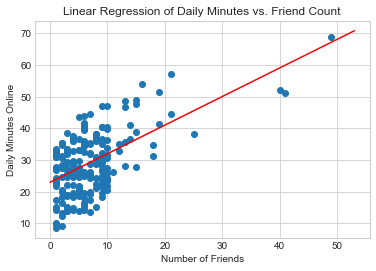

In [25]:
# plotting our 'line of best fit'
plt.style.use('seaborn-whitegrid') # neat
plt.title('Linear Regression of Daily Minutes vs. Friend Count')
plt.xlabel('Number of Friends')
plt.ylabel('Daily Minutes Online')
# our actual data
plt.scatter(num_friends_good, daily_minutes_good)
# our line of best fit
xs = range(0, max(num_friends_good) + 5)
ys = [alpha * x + beta for x in xs]
plt.plot(xs, ys, color='red')
plt.show()

### R-Squared: the coefficient of determination

We need a better way to figure out how well our line fits our data than just looking at the graph. We can use the *R-squared* value to give a numeric answer:

In [35]:
def total_sum_of_squares(ys: Vector) -> float:
    """
    For a given vector (in this R-squared context our y values), return the total squared distance from the mean
    """
    mu = mean(ys)
    return sum((y - mu)**2 for y in ys)

def r_squared(alpha: float, beta: float, xs: Vector, ys: Vector) -> float:
    """
    give the R-squared value of our line of best fit relative to actual data xs, ys. This is equivalent to the 
    fraction of the variance in ys that we account for in our predictions, itself equivalent to 1.0 - the fraction we
    miss
    """
    var_missed = sum_of_squared_errors(alpha, beta, xs, ys)
    var_present = total_sum_of_squares(ys)
    return 1.0 - (var_missed / var_present)
assert abs(r_squared(alpha, beta, num_friends_good, daily_minutes_good) - .329) < 10**-3

Our R value of `.329` isn't actually very good and implies are linear hypothesis doesn't adequately explain whats going on

### Using Gradient Descent

Sometimes its faster, sometimes its all that is tractable, sometimes there is no defined solution to the system of equations that minimizes least squared errors for all hypothesis functions (ours being single variable linear in this case). Anyway, we can use gradient descent to perform linear regression.

Recall we are predicting with the equation: 

$$ \hat{y_i} = \alpha x_i + \beta $$

Our loss $\lambda$ is then:

$$ loss(x_i, y_i) = (\hat{y_i} - y_i)^2  = (\alpha x_i + \beta - y_i)^2$$

We can compute partial gradients like so:

$$\frac{\partial \lambda}{\partial \alpha} =  2(\alpha x_i + \beta - y_i) * x_i $$

$$\frac{\partial \lambda}{\partial \beta} =  2(\alpha x_i + \beta - y_i) $$

In [74]:
num_epochs = 5000
random.seed(0)

guess = (random.random(), random.random())
lr = 10**-5
# lets do gradient descent!
xs = num_friends_good
ys = daily_minutes_good
losses = []
params = []
with tqdm.trange(num_epochs) as t:
    for _ in t:
        alpha, beta = guess
        params.append(guess)
        # partial derivative of alpha, beta
        grad_a = sum(2*error(alpha, beta, x, y)*x for x, y in zip(xs, ys))
        grad_b = sum(2*error(alpha, beta, x, y) for x, y in zip(xs, ys))
        loss = sum_of_squared_errors(alpha, beta, xs, ys)
        losses.append(loss)
        t.set_description(f"loss: {loss:.3f}")
        
        # finally, update the guess
        guess = gradient_step(guess, [grad_a, grad_b], -lr)
alpha, beta = guess
assert 22.9 < beta < 23
assert .9 < alpha < .905

loss: 13196.620: 100%|██████████| 5000/5000 [00:04<00:00, 1049.49it/s]


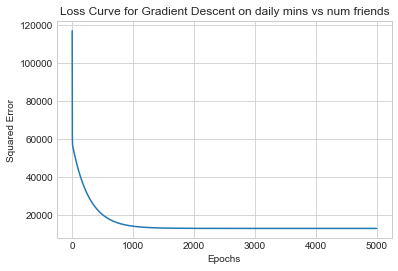

In [48]:
# Now we can plot a loss curve!
plt.title("Loss Curve for Gradient Descent on daily mins vs num friends")
plt.plot(range(num_epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Squared Error')
plt.show()

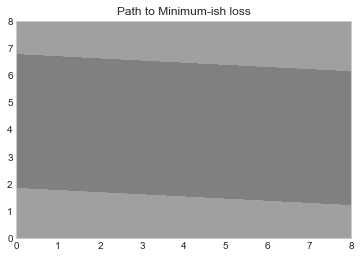

In [82]:
# We can also plot our path across theoretical losses
plt.title("Path to Minimum-ish loss")
# contour of losses: first define a grid (will be 0-9 * 0-9 and we'll shift to real values with an arg)
dim_x = np.arange(1, 10)
dim_y = dim_x.reshape(-1, 1)
loss_plane = dim_x * dim_y
min_loss = losses[-1]
max_loss = 0

# now set the actual values
for i in dim_x:
    for j in dim_x:
        a = (-1 + .2 * i) + alpha
        b = (-1 + .2 * j) + beta
        loss = sum_of_squared_errors(a, b, xs, ys)
        loss_plane[i - 1][j - 1] = loss
        max_loss = loss if loss > max_loss else max_loss
loss_diff = max_loss - min_loss
levels = [i for i in range(math.floor(min_loss) + 100, math.floor(max_loss) - 100, int(math.floor(loss_diff / 3.)))]
cs = plt.contourf(loss_plane, 
                  levels=levels,
                  colors=['#808080', '#A0A0A0', '#C0C0C0'],
                  extend='both')
cs.changed()


This doesn't actually do what I thought it would: turns out getting the right contour shape will be tough since alpha, beta aren't at the same scale. **This is also why gradient descent can struggle on un-scaled data**

#### Why least squares?

Blah blah math shows that the parameters of alpha, beta that provide the maximum likelihood estimate for any data defined by $ y_i = \alpha x_i + \beta + \epsilon $ are equivalent to those that minimize squared error. Importantly * this assumes that the $\eps